# ** Frozen Lake를 활용한 Q-learning 실습 **

# 1. Dummy Q-Learning

Success rate: 0.978
Final Q-Table Values
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
Left Down Right Up


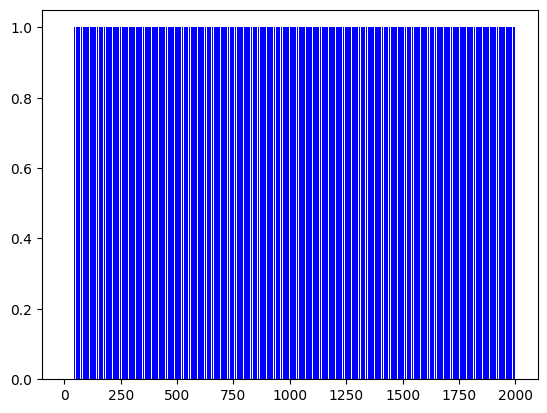

In [ ]:
import gym
from gym.envs.registration import register
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

# 방향에 따른 정수 매핑
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

# 초기에는 모든 방향이 다 0  이므로 random하게 방향을 선택해서 action을 취하도록 하는 함수 정의
def rargmax(vector):  # https://gist.github.com/stober/1943451
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return random.choice(indices)

# FrozenLake 설정
register(
    id='FrozenLake-v3',
    entry_point="gym.envs.toy_text:FrozenLakeEnv",
    kwargs={'map_name':'4x4','is_slippery':False}
) # 만약, action이 정해진 범위를 넘어서면(ex. (0, 0)에서 위로 이동하려 하는 경우) 이동하지 않고 해당 state 유지

# 환경 설정
env = gym.make("FrozenLake-v3")
# 초기에 Q-value는 전부 0으로 초기화(행:state, 열:action)
Q = np.zeros([env.observation_space.n, env.action_space.n])
# 학습 파라미터 설정(총 2000번 길찾기 수행)
num_episodes = 2000

# episode별 전체 보상과 단계를 저장할 리스트 생성
rList = []
result = pd.DataFrame()

# 여러번의 episode를 수행하면서 정답이 되는 길을 찾도록 함(episode를 진행하면서 q-table은 초기화하지 않음 : 다음 episode에서 q-value를 보고 길을 찾아야 하므로)
for i in range(num_episodes):
    # episode 수행시마다 state 초기화(다시 출발 지점으로)
    state = env.reset()
    rAll = 0
    rewards = []
    actions = []
    new_states = []
    done = False  # done=True : 집을 찾거나 물에 빠져 episode 종료

    # Q-table 학습 알고리즘
    while not done: # 집을 찾거나 물에 빠질 때까지(= 1 episode) 반복
        # 현재 state에서 random하게 action을 선택
        action = rargmax(Q[state, :])

        # action을 수행할 때마다의 새로운 state, 보상, 종료 여부, 추가 정보 확인
        new_state, reward, done, info = env.step(action)

        # 현재 위치와 행동별 Q-value(현재 보상 + 추후 행동에 대한 최대 보상)를 계산하여 Q-table 업데이트
        Q[state][action] = reward + np.max(Q[new_state, :])

        # action별 reward 출력시 가장 마지막 action만 reward가 1임(나머지는 0) : 가장 마지막 action으로 종료 상태에 도달하면서 reward를 받으므로
        rAll += reward # 총 보상
        state = new_state # 상태 변경(새로운 상태로 현재 상태 변경)

        rewards.append(str(int(reward)))
        actions.append(str(action))
        new_states.append(str(new_state))

    rList.append(rAll)

    # episode별 Q-table 확인하여 가중치가 어떻게 생성되는지 확인(엑셀 파일로 저장)
    rewardList = ', '.join(rewards)
    actionList = ', '.join(actions)
    NstateList = ', '.join(new_states)

    Qdf = pd.DataFrame(Q)
    Qdf['EPISODE'] = i+1
    Qdf['TOTAL_REWARD'] = rAll
    Qdf['REWARD_LIST'] = rewardList
    Qdf['ACTION_LIST'] = actionList
    Qdf['NEWSTATE_LIST'] = NstateList
    result = result.append(Qdf)

print("Success rate: " + str(sum(rList)/num_episodes))  # 성공 에피소드/ 총 에피소드(여기선 성공하면 1의 보상을 가져가므로 sum하면 성공 횟수와 동일)
print("Final Q-Table Values")
print(Q)
print("Left Down Right Up")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

env.close()

# 결과 그래프
# 초반에만 실패하고 뒤쪽은 대부분 성공
#=> 처음 길을 전부 찾아내기 전까지는 실패가 존재하지만 계속된 업데이트를 통해 길을 한번 찾아내면 그후론 매번 같은길로 가게 되므로 계속 성공

result.rename(columns = {0 : 'LEFT(0)', 1 : 'DOWN(1)', 2 : 'RIGHT(2)', 3 : 'UP(3)'}, inplace = True)
result = result [['EPISODE', 'LEFT(0)', 'DOWN(1)', 'RIGHT(2)', 'UP(3)', 'TOTAL_REWARD', 'ACTION_LIST', 'NEWSTATE_LIST', 'REWARD_LIST']]
# result.to_excel('result_dummy_qlearning.xlsx')

# 2. Exploration & Exploit : 최적화된 경로 찾기
- exploit : 이미 학습한 결과를 활용하여 현 상태에서 가장 최대의 보상을 얻을 수 있는 action을 수행하는 것
- exploration : 환경에 대한 정보를 얻을 수 있도록 새로운 action을 수행하는 것

In [ ]:
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import warnings
warnings.filterwarnings('ignore')

# FrozenLake 설정
register(
    id='FrozenLake-v3',
    entry_point="gym.envs.toy_text:FrozenLakeEnv",
    kwargs={'map_name':'4x4','is_slippery':False}
)

env = gym.make('FrozenLake-v3')

Q = np.zeros([env.observation_space.n, env.action_space.n])

# 할인율 설정(값이 클수록 미래의 action에 대한 reward를 많이 고려하고 작을수록 현재 reward를 많이 고려)
dis = .99
# 2000번의 episode 반복
num_episodes = 2000

rList = []
result = pd.DataFrame()

## 2-1. E-greedy

: e 값을 설정하고 random한 값이 e 보다 작으면 random한 action을 취하고 e보다 크면 미래 보상이 높은 action을 취하는 것


```
e = 0.1
if rand < e:
  a = random
else:
  a = argmax(Q(s, a))
```



Success rate: 0.3785
Final Q-Table Values
[[0.94148015 0.95099005 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.95099005 0.96059601]
 [0.96059601 0.         0.95099005 0.95099005]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059601]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.        ]
 [0.970299   0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]
Left Down Right Up


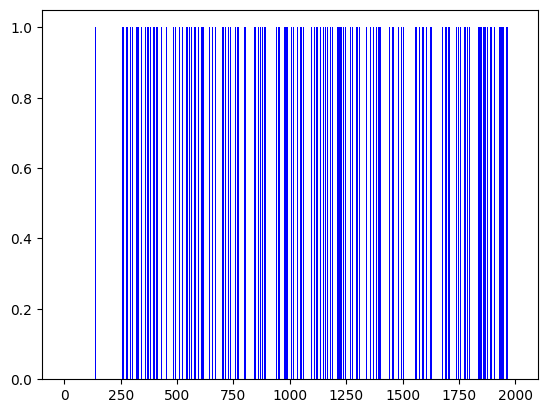

In [ ]:
for i in range(num_episodes):
    state = env.reset()
    rAll = 0
    rewards = []
    actions = []
    new_states = []
    done = False

    # epsilon : e의 확률로 exloration(탐험) 하고 나머지의 확률로 exploit(이용) 함
    e = .5

    while not done:
        # random한 값 p 설정
        p = np.random.rand(1)

        # 만약 p가 e보다 작으면 exploration함 = random한 action을 취함
        if p < e:
          action = env.action_space.sample()
        # p가 e 이상이면 exploit함 = 가장 높은 reward를 가지는 action을 취함
        else:
          action = np.argmax(Q[state, :])

        new_state, reward, done, info = env.step(action)
        # 미래 action의 reward에 할인율을 적용하여 현재 보상에 더함
        Q[state, action] = reward + dis * np.max(Q[new_state, :])

        rAll += reward
        state = new_state

        rewards.append(str(int(reward)))
        actions.append(str(action))
        new_states.append(str(new_state))

    rList.append(rAll)

    # episode별 Q-table 확인하여 q-value가 어떻게 생성되는지 확인(.xlsx)
    rewardList = ', '.join(rewards)
    actionList = ', '.join(actions)
    NstateList = ', '.join(new_states)

    Qdf = pd.DataFrame(Q)
    Qdf['EPISODE'] = i+1
    Qdf['TOTAL_REWARD'] = rAll
    Qdf['REWARD_LIST'] = rewardList
    Qdf['ACTION_LIST'] = actionList
    Qdf['NEWSTATE_LIST'] = NstateList
    result = result.append(Qdf)

# e(epsilon) 값을 어떻게 설정하느냐에 따라 성공률의 편차가 큼 -> 적절한 e 값을 설정하는 것이 중요
print("Success rate: " + str(sum(rList)/num_episodes))
print("Final Q-Table Values")
print(Q)
print("Left Down Right Up")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

env.close()

result.rename(columns = {0 : 'LEFT(0)', 1 : 'DOWN(1)', 2 : 'RIGHT(2)', 3 : 'UP(3)'}, inplace = True)
result = result [['EPISODE', 'LEFT(0)', 'DOWN(1)', 'RIGHT(2)', 'UP(3)', 'TOTAL_REWARD', 'ACTION_LIST', 'NEWSTATE_LIST', 'REWARD_LIST']]
# result.to_excel('result_Egreedy_qlearning.xlsx')

## 2-2. decaying E-greedy

 : 학습하는 초기에는 e 값을 크게 해서 random하게 가는 횟수를 늘리고 학습이 진행될수록 e 값이 작아져 왠만하면 최대 보상의 action을 취하는 것


```
for i in range(1000):
  e = 0.1/(i+1)

  if random(1) < e:
    a = random
  else:
    a = argmax(Q(s, a))
```



Success rate: 0.8105
Final Q-Table Values
[[0.94148015 0.95099005 0.93206535 0.94148015]
 [0.94148015 0.         0.92274469 0.93206535]
 [0.93206535 0.         0.         0.92274469]
 [0.         0.         0.         0.        ]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.        ]
 [0.970299   0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]
Left Down Right Up


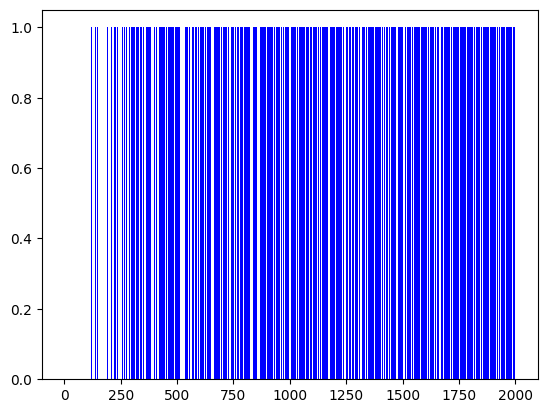

In [ ]:
for i in range(num_episodes):
    state = env.reset()
    rAll = 0
    rewards = []
    actions = []
    new_states = []
    done = False

    # epsilon : e의 확률로 exloration(탐험) 하고 나머지의 확률로 exploit(이용) 함
    # 이 때, episode를 반복할수록 분모의 값이 증가하며 e의 값은 감소함
    # => 초반에는 random하게 action을 취하여 탐험을 하고 후반에는 이미 아는 보상값을 활용하여 보상이 큰 값의 action을 취함
    #    초반에는 환경에 대한 지식이 무지하여 탐색이 필요하지만 후반부로 갈수록 어느정도 정확한 q-value를 알고 있기 때문에 알고 있는 정보를 활용하는 방식
    e = 1./((i//100)+1)

    while not done:
        # random한 값 p 설정
        p = np.random.rand(1)

        # 만약 p가 e보다 작으면 explore함 = random한 action을 취함
        if p < e:
          action = env.action_space.sample()
        # p가 e 이상이면 exploit함 = 가장 높은 reward를 가지는 action을 취함
        else:
          action = np.argmax(Q[state, :])

        new_state, reward, done, info = env.step(action)
        # 미래 action의 reward에 할인율을 적용하여 현재 보상에 더함
        Q[state, action] = reward + dis * np.max(Q[new_state, :])

        rAll += reward
        state = new_state

        rewards.append(str(int(reward)))
        actions.append(str(action))
        new_states.append(str(new_state))

    rList.append(rAll)

    # episode별 Q-table 확인하여 q-value가 어떻게 생성되는지 확인(.xlsx)
    rewardList = ', '.join(rewards)
    actionList = ', '.join(actions)
    NstateList = ', '.join(new_states)

    Qdf = pd.DataFrame(Q)
    Qdf['EPISODE'] = i+1
    Qdf['TOTAL_REWARD'] = rAll
    Qdf['REWARD_LIST'] = rewardList
    Qdf['ACTION_LIST'] = actionList
    Qdf['NEWSTATE_LIST'] = NstateList
    result = result.append(Qdf)

print("Success rate: " + str(sum(rList)/num_episodes))
print("Final Q-Table Values")
print(Q)
print("Left Down Right Up")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

env.close()

result.rename(columns = {0 : 'LEFT(0)', 1 : 'DOWN(1)', 2 : 'RIGHT(2)', 3 : 'UP(3)'}, inplace = True)
result = result [['EPISODE', 'LEFT(0)', 'DOWN(1)', 'RIGHT(2)', 'UP(3)', 'TOTAL_REWARD', 'ACTION_LIST', 'NEWSTATE_LIST', 'REWARD_LIST']]
# result.to_excel('result_decaying_Egreedy_qlearning.xlsx')

## 2-3. add random noise

: 완전한 random 방식보다 미래 보상에 noise를 더해 제일 높은 미래 보상의 action보다 차순위의 action을 취하는 것

```
for i in range(1000):
 a = argmax(Q(s, a) + random_values/(i+1))
```



Success rate: 0.9
Final Q-Table Values
[[0.         0.         0.95099005 0.        ]
 [0.         0.         0.96059601 0.        ]
 [0.         0.970299   0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.        ]
 [0.         0.99       0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.99       0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]
Left Down Right Up


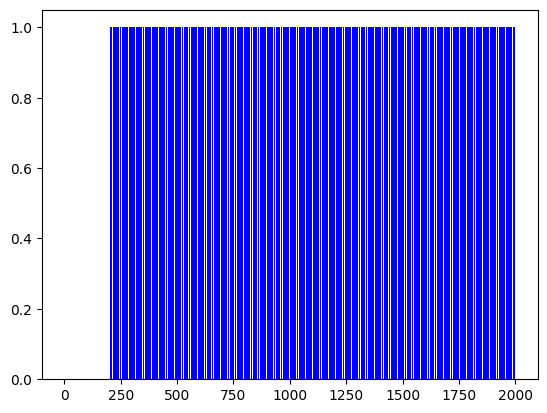

In [ ]:
for i in range(num_episodes):
    state = env.reset()
    rAll = 0
    rewards = []
    actions = []
    new_states = []
    done = False

    while not done:
        # action을 결정할 때 가능한 action에 random한 noise 값을 더해줌
        # 이 때, noise 값을 (i+1)로 나누는데, 이는 episode가 진행됨에 따라 더해주는 noise 값을 감소시키는 decaying을 적용시킬 수 있음
        # 이 경우 초반에는(=noise 값이 비교적 작지 않을 때) random한 noise로 인해 random한 action을 취하지만
        # 후반부(=noise 값이 점점 작아지면서)로 갈수록 완전한 random이라기 보다는 비교적 높은 보상값인 2, 3번째 action을 고를 확률이 높아짐
        action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n)/(i+1))

        new_state, reward, done, info = env.step(action)
        # 미래 action의 reward에 할인율을 적용하여 현재 보상에 더함
        Q[state, action] = reward + dis * np.max(Q[new_state, :])

        rAll += reward
        state = new_state

        rewards.append(str(int(reward)))
        actions.append(str(action))
        new_states.append(str(new_state))

    rList.append(rAll)

    # episode별 Q-table 확인하여 q-value가 어떻게 생성되는지 확인(.xlsx)
    rewardList = ', '.join(rewards)
    actionList = ', '.join(actions)
    NstateList = ', '.join(new_states)

    Qdf = pd.DataFrame(Q)
    Qdf['EPISODE'] = i+1
    Qdf['TOTAL_REWARD'] = rAll
    Qdf['REWARD_LIST'] = rewardList
    Qdf['ACTION_LIST'] = actionList
    Qdf['NEWSTATE_LIST'] = NstateList
    result = result.append(Qdf)

print("Success rate: " + str(sum(rList)/num_episodes))
print("Final Q-Table Values")
print(Q)
print("Left Down Right Up")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

env.close()

result.rename(columns = {0 : 'LEFT(0)', 1 : 'DOWN(1)', 2 : 'RIGHT(2)', 3 : 'UP(3)'}, inplace = True)
result = result [['EPISODE', 'LEFT(0)', 'DOWN(1)', 'RIGHT(2)', 'UP(3)', 'TOTAL_REWARD', 'ACTION_LIST', 'NEWSTATE_LIST', 'REWARD_LIST']]
# result.to_excel('result_noise_decaying_Egreedy_qlearning.xlsx')

# 3. Deterministic vs Stochastic

Success rate: 0.634
Final Q-Table Values
[[7.14021256e-01 1.48379196e-02 9.73481914e-03 9.88337724e-03]
 [8.43290527e-07 2.11273554e-04 1.36977852e-03 5.75469364e-01]
 [1.30561432e-03 9.80846432e-04 1.22061211e-03 4.54629478e-01]
 [4.27802005e-03 1.35882045e-03 1.44429134e-03 4.40298349e-01]
 [6.30866277e-01 8.43864641e-04 1.10445488e-04 4.95400444e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.67501113e-04 1.92493737e-04 6.01438036e-01 3.49791971e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.93967097e-04 7.16914189e-04 1.68123362e-03 7.89134279e-01]
 [1.65343165e-03 9.42256040e-01 0.00000000e+00 1.48384633e-03]
 [9.79351929e-01 3.66851490e-04 3.58512269e-05 1.80588624e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.52838826e-03 9.81776876e-01 0.00000000e+00]
 [0.00000000e+00 9.99216050e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+

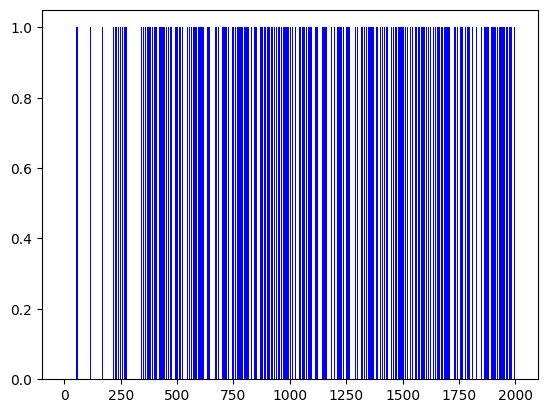

In [3]:
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import warnings
warnings.filterwarnings('ignore')

# 환경 설정 : 해당 환경은 'is_slippery':True 인 환경 (특정 action을 지시해도 얼음판에 미끄러져 전혀 다른 action을 취하게 될 확률이 존재)
env = gym.make("FrozenLake-v1")
# 초기에 Q-value는 전부 0으로 초기화(행:상태, 열:행동)
Q = np.zeros([env.observation_space.n, env.action_space.n])

# 할인율 설정(값이 클수록 미래의 action에 대한 reward를 많이 고려하고 작을수록 현재 reward를 많이 고려)
dis = .99
num_episodes = 2000
learning_rate = 0.85

rList = []
result = pd.DataFrame()


# episode별 전체 보상과 단계를 저장할 리스트 생성
rList = []
result = pd.DataFrame()

# 여러번의 episode를 수행하면서 최적의 길을 찾도록 함(episode를 진행하면서 q-table은 reset 하지 않음 : 다음 episode에서 q-value를 보고 길을 찾아야 하므로)
for i in range(num_episodes):
    # episode 수행시마다 state reset
    state = env.reset()
    rAll = 0
    rewards = []
    actions = []
    new_states = []
    done = False  # done=True : 집을 찾거나 물에 빠져 episode 종료

    # Q-table 학습 알고리즘
    while not done: # 집을 찾거나 물에 빠질 때까지 반복
        # add random noise(+decaying E-greedy)를 통한 action 수행
        action = np.argmax(Q[state, :] + np.random.randn(1, env.action_space.n)/(i+1))

        # action을 수행할 때마다의 state, 보상, 종료 여부, 추가 정보 확인
        new_state, reward, done, info = env.step(action)

        # 새로운 Q 값에 learning_rate를 적용하여 기존 Q-value를 토대로 조금씩 업데이트 -> 새로운 Q를 완전히 믿기보다는 기존의 Q 값을 바탕으로 새로운 Q를 조금씩 학습하여 업데이트 해나감
        Q[state][action] = (1-learning_rate) * Q[state, action] + learning_rate * (reward + dis * np.max(Q[new_state, :]))

        rAll += reward # 총 보상
        state = new_state # 상태 변경(새로운 상태로 현재 상태 변경)

        rewards.append(str(int(reward)))
        actions.append(str(action))
        new_states.append(str(new_state))

    rList.append(rAll)

    # episode별 Q-table 확인하여 q-value가 어떻게 생성되는지 확인(.xlsx)
    rewardList = ', '.join(rewards)
    actionList = ', '.join(actions)
    NstateList = ', '.join(new_states)

    Qdf = pd.DataFrame(Q)
    Qdf['EPISODE'] = i+1
    Qdf['TOTAL_REWARD'] = rAll
    Qdf['REWARD_LIST'] = rewardList
    Qdf['ACTION_LIST'] = actionList
    Qdf['NEWSTATE_LIST'] = NstateList
    result = result.append(Qdf)

print("Success rate: " + str(sum(rList)/num_episodes))  # 성공 에피소드/ 총 에피소드(여기선 성공하면 1의 보상을 가져가므로 sum하면 성공 횟수와 동일)
print("Final Q-Table Values")
print(Q)
print("Left Down Right Up")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

env.close()


result.rename(columns = {0 : 'LEFT(0)', 1 : 'DOWN(1)', 2 : 'RIGHT(2)', 3 : 'UP(3)'}, inplace = True)
result = result [['EPISODE', 'LEFT(0)', 'DOWN(1)', 'RIGHT(2)', 'UP(3)', 'TOTAL_REWARD', 'ACTION_LIST', 'NEWSTATE_LIST', 'REWARD_LIST']]
# result.to_excel('result_stochastic_qlearning.xlsx')